## Tutorial: Least Squares example


In this tutorial, we will see an initial example on an already existing problem inside the DASF toolbox. The tutorial mainly emphasize how to setup the problem and various variables, and shows two different simulations settings: the stationary and the non-stationary ones.

Throughout this notebook, we will use the Minimum Mean Square Error (MMSE) problem as an example, written as:

$\text{min}_X\; \mathbb{E}[||\mathbf{d}(t)-X^T\mathbf{y}(t)||^2],$

in a distributed setting using the DASF framework.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from dasftoolbox import NetworkGraph, ConvergenceParameters
from dasftoolbox.optimization_problems.mmse_problem import MMSEProblem
from dasftoolbox.data_retrievers.mmse_data_retriever import MMSEDataRetriever
from dasftoolbox import DataWindowParameters
from dasftoolbox import DASF

random_seed = 2025
rng = np.random.default_rng(random_seed)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


The network on which the MMSE problem will be solved is created randomly,
and has 10 nodes and 5 channels/sensors per node.


In [ ]:
# Number of nodes
nb_nodes = 10
# Number of channels per node
nb_sensors_per_node = (5 * np.ones(nb_nodes)).astype(int)
# Create adjacency matrix (hollow matrix) of a random graph
adjacency_matrix = rng.integers(0, 1, size=(nb_nodes, nb_nodes), endpoint=True)
adjacency_matrix = np.triu(adjacency_matrix, 1) + np.tril(adjacency_matrix.T, -1)
network_graph = NetworkGraph(
    nb_nodes=nb_nodes,
    nb_sensors_per_node=nb_sensors_per_node,
    adjacency_matrix=adjacency_matrix,
)

The adjacency matrix of the network is:


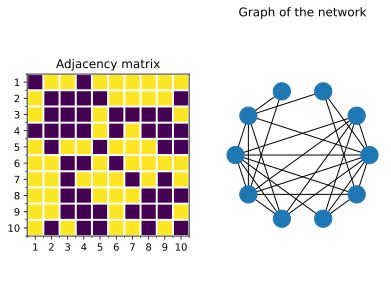

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

fig = network_graph.plot_graph()


We will now use the **`DataRetriever`** class to get the problem inputs. We choose the number of samples per window of $\mathbf{y}$ and $\mathbf{d}$ to be equal to 10000, generated synthetically using the **`MMSEDataRetriever`** class, while we consider 500 data/signal windows in total. We choose the number of filters (i.e., the number of columns of $X$ or the dimension of the filtered signal $X^T\mathbf{y}$) to be equal to 5.

Initially, we will simulate a stationary setting, therefore, we will keep the same window of `Y` for all iterations, which can be done by setting `nb_window_reuse` to the number of iterations desired, which we choose to be `300`, and `sliding_window_offset` to `0` in **`DataWindowParameters`**. In this way, the first window of data will be reused over all iterations. The **`get_stationary_setting`** function can be used as well for this purpose.


In [ ]:
from dasftoolbox import get_stationary_setting

# Number of samples per window of the signals
nb_samples_per_window = 10000

# Number of windows in total
nb_windows = 500

# Number of filters of X
nb_filters = 5

max_iterations = 300
data_window_params = get_stationary_setting(
    window_length=nb_samples_per_window, iterations=max_iterations
)

mmse_data_retriever = MMSEDataRetriever(
    data_window_params=data_window_params,
    nb_sensors=network_graph.nb_sensors_total,
    nb_sources=nb_filters,
    nb_windows=nb_windows,
    rng=rng,
)

Note that we use the class **`ProblemInputs`** to put all inputs of the problem in a standard format, to be used by both the centralized and DASF solvers. This is done inside **`MMSEDataRetriever`**.

More specifically, since we have one signal $\mathbf{y}$ to be fused with $X$ through $X^T\mathbf{y}$ and one target $\mathbf{d}$ that is not fused, in **`ProblemInputs`**, `fused_signals` and `global_parameters` will have one element while the other attributes will be empty. The attribute `fused_signals[0]` will consist of the matrix `Y` containing in its columns time samples of $\mathbf{y}$:
$Y = [\mathbf{y}(1);\dots;\mathbf{y}(10000)]$, while `global_parameters[0]` will be $D = [\mathbf{d}(1);\dots;\mathbf{d}(10000)]$. The method `get_data_window` will be called to get new inputs by providing a different window ID.

For example, to obtain the first window of data/signals, we can use:


In [ ]:
mmse_inputs = mmse_data_retriever.get_data_window(window_id=0)

When solving the MMSE problem in the DASF setting, we need to use a centralized solver to
solve the local problems created at each different node, where each node solves a parameterized
version of the original problem. The solver we use is **`MMSEProblem`**`.solve` which solves:

$\text{min}_X\; \mathbb{E}[||\mathbf{g}_1(t)-X^T\mathbf{y}_1(t)||^2].$

Comparing it with problem $P$, we see that we have $\mathbf{y}_1=\mathbf{y}$ and
$\mathbf{g}_1=\mathbf{d}$.


The optimal filter $X^*$ is estimated using the centralized solver **`MMSEProblem`**`.solve` taking
as input `mmse_inputs`.


In [43]:
mmse_problem = MMSEProblem(nb_filters=nb_filters)
X_star = mmse_problem.solve(problem_inputs=mmse_inputs, save_solution=True)
f_star = mmse_problem.evaluate_objective(X_star, problem_inputs=mmse_inputs)

For the distributed context, we take the previously created network, and choose a randomly
generated sequence as the updating path, i.e., the order in which the nodes take turns
in solving their local problem.

We also fix the number of iterations of the DASF algorithm to be equal to 500. We do not specify the other stopping conditions for the DASF algorithm, namely reaching a certain threshold on $\|X^{i+1}-X^i\|_F$ or $|f(X^{i+1})-f(X^i)|$, therefore the DASF algorithm will make exactly 500 iterations.


In [44]:
dasf_convergence_parameters = ConvergenceParameters(max_iterations=max_iterations)

We build the DASF solver as follows. `update_path` provides a predetermined seuqence of updating nodes to the DASF algorithm which will be used to sequentially select the updating nodes.


In [ ]:
update_path = rng.permutation(range(nb_nodes))
dasf_mmse_stationary_solver = DASF(
    problem=mmse_problem,
    data_retriever=mmse_data_retriever,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
)

INFO:dasftoolbox.dasf:No connvergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).


The DASF algorithm is then called by using the `run` method. Each node $q$ will solve a parameterized/compressed version of the problem $P$
given by:

$\text{min}_{\widetilde{X}_q}\; \mathbb{E}[||\mathbf{d}(t)-\widetilde{X}_q^TC_q^T\mathbf{y}(t)||^2],$

which is again an MMSE problem, where the inputs are compressed versions of the original one.


In [46]:
dasf_mmse_stationary_solver.run()

Let us look at the plot of the normalized error $\frac{||X^i-X^*||_F^2}{||X^*||_F^2}$:


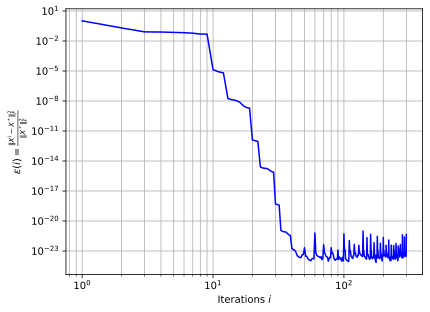

In [47]:
fig = dasf_mmse_stationary_solver.plot_error()

An overall summary of the run can be obtained using the **`get_summary_df`** method.


In [ ]:
stationary_run_summary = dasf_mmse_stationary_solver.get_summary_df()
stationary_run_summary.head()

,iterations,iterate_difference,error,objective_error,updating_node,number_of_neighbors,batch
0,1,1.153062,1.031913,0.024642,1,5,1
1,2,0.001296,0.200951,0.004755,5,7,1
2,3,0.000190,0.081531,0.001716,4,6,1
3,4,0.000003,0.078584,0.001669,7,5,1
4,5,0.000006,0.071990,0.001587,3,2,1


Let's now look at a non-stationary setting. For this purpose, we will generate synthetic data with changing statistics in time. Now the DASF algorithm will only use a window of data once, and retrieve the next window at the next iteration. When we do not specify the sliding window offset, it is automatically set equal to `window_length`, such that the next window is the closest window with no overlap with the current one.


In [49]:
data_window_params = DataWindowParameters(
    window_length=nb_samples_per_window,
    nb_window_reuse=1,
)

mmse_data_retriever = MMSEDataRetriever(
    data_window_params=data_window_params,
    nb_sensors=network_graph.nb_sensors_total,
    nb_sources=nb_filters,
    nb_windows=nb_windows,
    rng=rng,
)

In [ ]:
dasf_convergence_parameters = ConvergenceParameters(
    max_iterations=nb_windows * data_window_params.nb_window_reuse
)

dasf_mmse_nonstationary_solver = DASF(
    problem=mmse_problem,
    data_retriever=mmse_data_retriever,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
)

INFO:dasftoolbox.dasf:No connvergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).


In [62]:
dasf_mmse_nonstationary_solver.run()

This time, the plot shows how abrupt changes in signal statistics lead to a sudden increase in error, and then return to lower values when the changes are smoother, where the changes in statistics are parameterized by the weight function shown below.


Text(0, 0.5, 'Weight function')

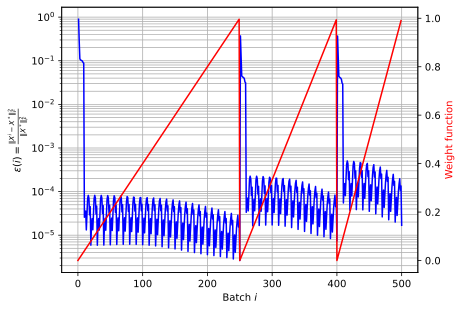

In [ ]:
import matplotlib.pyplot as plt

fig = dasf_mmse_nonstationary_solver.plot_error_over_batches()
ax = plt.gca()
ax.set_xscale("linear")
ax2 = ax.twinx()
ax2.plot(mmse_data_retriever.weight_function(nb_windows), "r")
ax2.set_ylabel("Weight function", color="r")